## Problem Statement

For a given future solution word on a future date, develop a model that allows you to predict the distribution of the reported results. In other words, to predict the associated percentages of (1, 2, 3, 4, 5, 6, X) for a future date. What uncertainties are associated with your model and predictions? Give a specific example of your prediction for the word EERIE on March 1, 2023. How confident are you in your model’s prediction?

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

First, read the dates and the corresponding data.

In [30]:
df = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,C,D,E,F:L")
df = df.sort_index()

### Repeatedness of characters (ROC)

We define the ROC of a word by calculating the information entropy of characters in a word, such that

$$ H(X):=-\sum _{x\in\mathcal{X}}p(x)\log p(x)=\mathbb{E}[-\log p(X)]. $$

In [31]:
def charCount(s):
    dic = {}
    for ch in s:
        try:
            dic[ch] += 1
        except KeyError:
            dic[ch] = 1
    return dic

def calc_roc(s): 
    dic = charCount(s)
    l = [val for val in dic.values()]
    return stats.entropy(l)

ROC increases as the repeatedness of letters in a character drops.

In [32]:
print("ROC of mummy:", calc_roc("mummy"))
print("ROC of apple:", calc_roc("apple"))
print("ROC of audio:", calc_roc("audio"))

ROC of mummy: 0.9502705392332347
ROC of apple: 1.3321790402101223
ROC of audio: 1.6094379124341005


### Percentage of Vowels (POV)

We define the POV of a word by calculating the percentage of vowel characters in a word.

In [33]:
def calc_pov(s):
    I2 = 0
    for c in s:
        if c in ["a", "e", "i", "o", "u"]: I2 += 1
    return I2 / 5

POC increases and the percentage of vowels in a word increases.

In [34]:
print("POV of mummy:", calc_pov("mummy"))
print("POV of apple:", calc_pov("apple"))
print("POV of audio:", calc_pov("audio"))

POV of mummy: 0.2
POV of apple: 0.4
POV of audio: 0.8


### Expectation of yellow hit (EYH) and expectation of green hit (EGH)

*Any formal mathematical definition? @Linyi*

In [35]:
totWords = 2309
charRank = {'a': 906, 'b': 266, 'c': 446, 'd': 370, 'e': 1053, 'f': 206, 'g': 299, 'h': 377, 'i': 646, \
            'j': 27, 'k': 202, 'l': 645, 'm': 298, 'n': 548, 'o': 672, 'p': 345, 'q': 29, 'r': 835, \
            's': 617, 't': 667, 'u': 456, 'v': 148, 'w': 193, 'x': 37, 'y': 416, 'z': 35}
charRankByPos = [{'a': 140, 'b': 173, 'c': 198, 'd': 111, 'e': 72, 'f': 135, 'g': 115, 'h': 69, \
                  'i': 34, 'j': 20, 'k': 20, 'l': 87, 'm': 107, 'n': 37, 'o': 41, 'p': 141, 'q': 23, \
                  'r': 105, 's': 365, 't': 149, 'u': 33, 'v': 43, 'w': 82, 'y': 6, 'z': 3}, \
                 {'a': 304, 'b': 16, 'c': 40, 'd': 20, 'e': 241, 'f': 8, 'g': 11, 'h': 144, 'i': 201, 'j': 2, \
                  'k': 10, 'l': 200, 'm': 38, 'n': 87, 'o': 279, 'p': 61, 'q': 5, 'r': 267, 's': 16, 't': 77, \
                  'u': 185, 'v': 15, 'w': 44, 'x': 14, 'y': 22, 'z': 2}, {'a': 306, 'b': 56, 'c': 56, 'd': 75, \
                  'e': 177, 'f': 25, 'g': 67, 'h': 9, 'i': 266, 'j': 3, 'k': 12, 'l': 112, 'm': 61, 'n': 137, 'o': 243, \
                  'p': 57, 'q': 1, 'r': 163, 's': 80, 't': 111, 'u': 165, 'v': 49, 'w': 26, 'x': 12, 'y': 29, 'z': 11}, \
                 {'a': 162, 'b': 24, 'c': 150, 'd': 69, 'e': 318, 'f': 35, 'g': 76, 'h': 28, 'i': 158, 'j': 2, \
                  'k': 55, 'l': 162, 'm': 68, 'n': 182, 'o': 132, 'p': 50, 'r': 150, 's': 171, 't': 139, 'u': 82, \
                  'v': 45, 'w': 25, 'x': 3, 'y': 3, 'z': 20}, {'a': 63, 'b': 11, 'c': 31, 'd': 118, 'e': 422, 'f': 26, \
                  'g': 41, 'h': 137, 'i': 11, 'k': 113, 'l': 155, 'm': 42, 'n': 130, 'o': 58, 'p': 56, 'r': 212, 's': 36, \
                  't': 253, 'u': 1, 'w': 17, 'x': 8, 'y': 364, 'z': 4}]

In [36]:
def calc_rank():
    with open("./dataset/wordle_wordbank.txt") as f:
        lines = f.readlines()
    print(len(lines))
    lines = [s.strip()for s in lines]
    dic = {}
    dic2 = [{} for _ in range(5)]
    for s in lines:
        for c in set(s.lower()):
            try: dic[c] += 1
            except KeyError: dic[c] = 1
        for i, c in enumerate(s):
            try: dic2[i][c] += 1
            except KeyError: dic2[i][c] = 1
    return dict(sorted(dic.items())), [dict(sorted(dic2[i].items())) for i in range(5)]

def calc_EYH(s):
    I3 = 0
    for c in set(s):
        I3 += charRank[c] / totWords
    return I3

# I3G is expectation of green hits
def calc_EGH(s):
    I3 = 0
    for i, c in enumerate(s):
        I3 += charRankByPos[i][c] / totWords
    return I3

*Any further explanation of the EYH and EGH? For instance, how to correlates with the easiness of a guess, etc. @Linyi*

In [37]:
print("mummy: EYH = {}, EGH = {}".format(calc_EYH("mummy"), calc_EGH("mummy")))
print("apple: EYH = {}, EGH = {}".format(calc_EYH("apple"), calc_EGH("apple")))
print("audio: EYH = {}, EGH = {}".format(calc_EYH("audio"), calc_EGH("audio")))

mummy: EYH = 0.5067128627111304, EGH = 0.33997401472498917
apple: EYH = 1.2771762667821567, EGH = 0.364660025985275
audio: EYH = 1.3209181463837156, EGH = 0.2667821567778259


### Check the correlation

In [38]:
def get_result(df, func_name, row_name):
    valAttrib = [func_name(word.strip()) for word in df["word"]]
    res = np.asarray(df[row_name])
    pearson = np.corrcoef(valAttrib, res)
    return pearson[0][1]

cols = ["trial_" + str(i) for i in range(1, 7)] + ["trial_x"]
attribs = [calc_roc, calc_pov, calc_EYH, calc_EGH]
labels = ["ROC", "POV", "EYH", "EGH"]
dic = {}
for i in range(len(attribs)): 
    l = []
    for colname in cols:
        l.append(get_result(df, attribs[i], colname))
    dic[labels[i]] = l
res = pd.DataFrame(dic, index=["tr1", "tr2", "tr3", "tr4", "tr5", "tr6", "trX"])

We will plot the correlation as a heat map, where the blue colors indicate strong negative correlation, the orange colors indicate strong positive correlation, and the shaded colors represent relatively weak correlations. More specifically, $>0.5$ is considered strong, $>0.3$ is considered moderate, and otherwise considered weak.

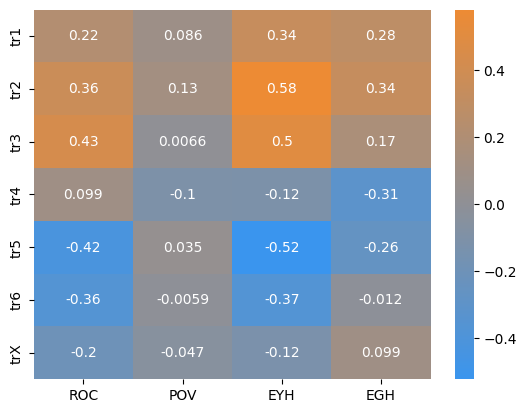

In [39]:
sns.heatmap(res, annot=True, cmap=sns.color_palette("blend:#3A95EE,#ED8B34", as_cmap=True))
plt.show()

Explicitly print out the correlations.

In [40]:
for index, row in res.iterrows():
    for item, val in row.items():
        if val >= 0.5:
            print("{} vs. {}: strong positive, {:.4f}".format(index, item, val))
        elif val >= 0.3:
            print("{} vs. {}: moderate positive, {:.4f}".format(index, item, val))
        elif val <= -0.5:
            print("{} vs. {}: strong negative, {:.4f}".format(index, item, val))
        elif val <= -0.3:
            print("{} vs. {}: moderate negative, {:.4f}".format(index, item, val))

tr1 vs. EYH: moderate positive, 0.3385
tr2 vs. ROC: moderate positive, 0.3624
tr2 vs. EYH: strong positive, 0.5808
tr2 vs. EGH: moderate positive, 0.3351
tr3 vs. ROC: moderate positive, 0.4329
tr3 vs. EYH: strong positive, 0.5016
tr4 vs. EGH: moderate negative, -0.3115
tr5 vs. ROC: moderate negative, -0.4192
tr5 vs. EYH: strong negative, -0.5220
tr6 vs. ROC: moderate negative, -0.3613
tr6 vs. EYH: moderate negative, -0.3685
